National instrument USB-6002 DAQ example

In [1]:
# write and read from the FSM and compare with LabVIEW vi
import nidaqmx
import numpy as np
from collections import deque
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from skimage import data
from skimage.feature import match_template

from LowLevelModules.NIdaq import *
from LowLevelModules.NIdaqAPD import *

from LowLevelModules.GeneralFunctions import *

from collections import deque
import time

In [80]:
time.sleep(1)

In [3]:
def acquire_one_voltage():
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan('/Dev2/ai0', 'USB ai0')
        curr_v = task.read()
    return curr_v

In [19]:
acquire_one_voltage()

0.0763440846640151

In [25]:
def acquire_at_rate(rate,npnts):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan('/Dev2/ai0', 'USB ai0')
        task.timing.cfg_samp_clk_timing(rate= rate, 
                                        active_edge=nidaqmx.constants.Edge.RISING ,
                                        sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
                                        samps_per_chan=npnts)   
#         self.triggers.start_trigger.cfg_dig_edge_start_trig(trig_src,nidaqmx.constants.Edge.FALLING  )
        
        task.start()
        aiv=task.read(number_of_samples_per_channel=npnts)
    return aiv

<IPython.core.display.Javascript object>


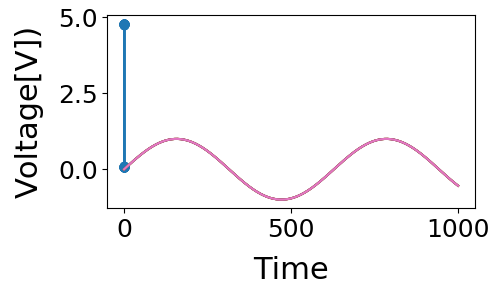

In [40]:
aiv=acquire_at_rate(50000,100)
xx = np.linspace(0,1,100)
lp = LivePlot(1, 1, 5, 3, 'o', 'Time', 'Voltage[V])')
lp.plot_live(xx, aiv)
# plt.plot(aiv)

In [12]:
def generate_one_voltage(v):
    with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan('/Dev2/ao1', 'USB ao1', min_val=-5, max_val=5)
        task.write(v)
        task.wait_until_done(timeout=5)

In [20]:
generate_one_voltage(1)

In [45]:
# for PLE, need to update voltage one at a time
# we can also to a voltage sweep if need be

In [9]:
varray=np.sin(np.linspace(0,10,1000))

In [10]:
def generate_many_voltage(varray,rate):
    with nidaqmx.Task() as task:
        npnts=len(varray)
        task.ao_channels.add_ao_voltage_chan('/Dev2/ao1', 'USB ao1')
        task.timing.cfg_samp_clk_timing(rate= rate, 
                                active_edge=nidaqmx.constants.Edge.RISING ,
                                sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
                                samps_per_chan=npnts)
#         task.triggers.start_trigger.cfg_dig_edge_start_trig(trig_src,nidaqmx.constants.Edge.RISING)        
        task.write(varray, auto_start=True, timeout=5)
#         task.start()
        task.wait_until_done(timeout=5)

In [11]:
generate_many_voltage(varray,1000)

In [5]:
# For Fabry-Perot scan, we need to scan and read voltage
# similar to FSM
# generate voltage at a rate
# read voltage at a rate
# both of them are triggered by say PFI0
# with say internally P0.0 connected to PFI1 for internal trigger

# input range is -10 to 10 V, step size 0.3 mV
# need to make sure we have enough light
# also need to terminate input by 1 MOhm or some other well controlled value
# for now, let's 

# say ao0 - FP cavity
# ao1 - laser

# let's use the digital output to drive PFI0 and PFI1 

# output positive voltages
# say with 1 mV step
# 0 to 6 V -> 6001 different values


<IPython.core.display.Javascript object>


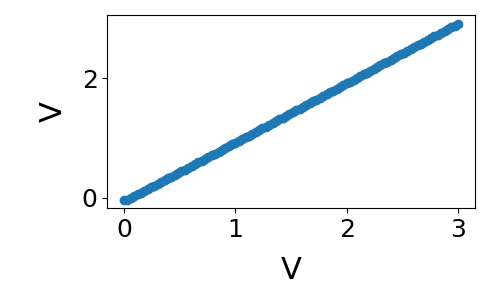

In [2]:
ao_pts = 100
v_ao_scan = np.linspace(0,3,ao_pts)
ao_scan_rate = 200
ao_trig_src =  '/Dev2/PFI0'
ai_trig_src =  '/Dev2/PFI1'


# configure digital channel to output 0
dig_trig = DO('/Dev2/port0/line0')
dig_trig.write(False)

# set up  AO AI
FPtask=AO('/Dev2/ao0')

FPtask.write(0)
time.sleep(2)

FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
cavityPDtask = AI('/Dev2/ai0')
cavityPDtask.config_read_rising(ao_pts,ao_scan_rate,ai_trig_src)
dig_trig.write(True)

FPtask.wait_until_done()
FPtask.close()
aiV=cavityPDtask.read(number_of_samples_per_channel=ao_pts)

cavityPDtask.close()

dig_trig.close()

lp = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp.plot_live(v_ao_scan,aiV)

# fig=plt.figure()
# plt.plot(aiV)


0.030303030303030304


<IPython.core.display.Javascript object>


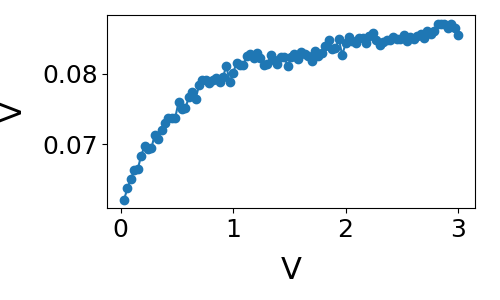

In [4]:
print(v_ao_scan[1])
v_diff=v_ao_scan-aiV
v_diff[0]=np.nan

lp2 = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp2.plot_live(v_ao_scan,v_diff)

In [23]:

FPtask.close()

cavityPDtask.close()

dig_trig.close()

c:\users\fuchsdiamond\appdata\local\programs\python\python37\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<14>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)
c:\users\fuchsdiamond\appdata\local\programs\python\python37\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<15>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)
c:\users\fuchsdiamond\appdata\local\programs\python\python37\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<F>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)


In [24]:
FPtask.close()

In [24]:
FPtask=AO('/Dev2/ao0')
# FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
cavityPDtask = AI('/Dev2/ai0')

In [60]:
FPtask.write(-5)

cavityPDtask.read()


-5.03298688607174

In [53]:
a=cavityPDtask.read()

In [42]:
vreadlist[0]=2

In [75]:
FPtask.write(-5)

1

In [76]:
FPtask.write(-5)
time.sleep(2)
vlist= np.linspace(-5,5,100)

vreadlist = np.zeros(100)
for ind,v in enumerate(vlist):
    FPtask.write(v)
    FPtask.wait_until_done()
    time.sleep(0.05)
    vreadlist[ind]=cavityPDtask.read()
#     print(ind,vreadlist[ind])


<IPython.core.display.Javascript object>


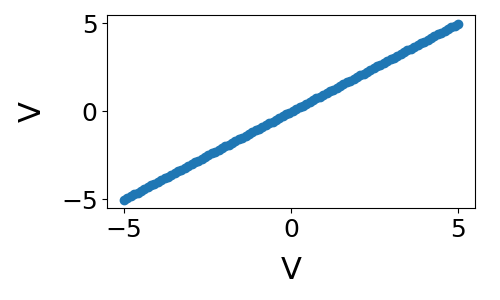

In [77]:
lp3 = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp3.plot_live(vlist,vreadlist)

In [72]:
v_diff = vlist-vreadlist

<IPython.core.display.Javascript object>


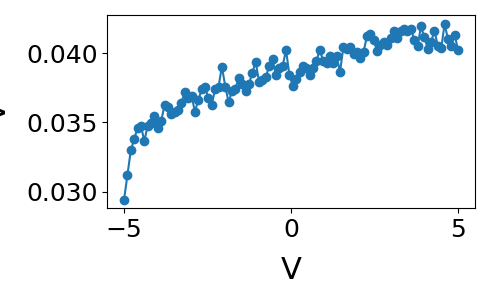

In [78]:
lp4 = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp4.plot_live(vlist,v_diff)